# Machine learning: prediction

Machine learning-trained algorithms can predict whether bioacoustic recordings contain a sound of interest. For instance, an algorithm trained how to detect the sound of a Wood Thrush can be used to predict where Wood Thrushes vocalize in a set of autonomous recordings. 

The Kitzes Lab, the developers of OpenSoundscape, pre-trained a series of [baseline machine learning models](https://pitt.app.box.com/s/3048856qbm9x55yi3zfksa3fide5uuf4) that can be used to predict the presence of [485 species of common North American birds](https://pitt.box.com/s/v0iy8pwctdxaiw9m0xa4a9lnmxv3p30b). These are "beta" models; if you are interested in using them for research, please contact us at the [Kitzes Lab](https://kitzeslab.org). Information about the training process is available at this [README](https://pitt.app.box.com/s/6s0ycvbrcxtk2ll6kj7iuhd3kjhufes5).

This tutorial downloads an example model and demonstrates how to use it to predict the identity of birds in recordings. To download the tutorial as a Jupyter Notebook, click the "Edit on GitHub" button at the top right of the tutorial. To run the Jupyter Notebook tutorial, follow [these instructions](installation.html#installation) to install OpenSoundscape and add the OpenSoundscape environment to your Jupyter kernels.

## Import modules
Import the following modules to run a pre-trained machine learning learning classifier. First, from OpenSoundscape we will need two classes (`Audio` and `SingleTargetAudioDataset`) and three functions (`run_command`, `lowercase_annotations`, and `predict`).

In [1]:
from opensoundscape.audio import Audio
from opensoundscape.datasets import SingleTargetAudioDataset
from opensoundscape.helpers import run_command
from opensoundscape.raven import lowercase_annotations
from opensoundscape.torch.predict import predict

Import the following machine learning-related modules. OpenSoundscape uses PyTorch to do machine learning.

In [2]:
import torch
import torch.nn
import torchvision.models
import torch.utils.data
import torchvision.transforms

Lastly, use a few miscellaneous functions.

In [3]:
import yaml
import os.path
import pandas as pd
from pathlib import Path
from math import floor
import matplotlib.pyplot as plt

## Download model

To use the model, it must be downloaded onto your computer and loaded with the same specifications it was created with.

Download the example model for Wood Thrush, *Hylocichla mustelina*. First, create a folder called `"prediction_example"` to store the model and its data in.

In [4]:
folder_name = "prediction_example"
folder_path = Path(folder_name)
if not folder_path.exists(): folder_path.mkdir()

Next, download the model from the Box storage site using the following lines. 

If you prefer, you can also download the model directly off of the shared folder (see introduction paragraphs). Make sure to move it into the `"prediction_example"` folder and ensure that it is named `"hylocichla-mustelina.tar"`. These instructions can be modified for any of the species included in the pre-trained set of models.

In [5]:
def download_from_box(link, name):
    run_command(f"curl -L {link} -o ./{name}")

This link format enables direct download.

In [6]:
link_to_model = "https://pitt.box.com/shared/static/0xl7aqjlhdrx83am7k4w0e72fsg08dey.tar"

Now, use the function created above to download the model file. 

In [7]:
model_filename = folder_path.joinpath("hylocichla-mustelina.tar")
download_from_box(
    link=link_to_model,
    name=model_filename,
)

Make sure that the model was downloaded correctly.

In [8]:
assert(model_filename.exists())

## Load model
At its core, a machine learning model consists of two things: its architecture and its weights. 

### Create architecture
The architecture is the complex structure of the model, which in this case, is a convolutional neural network. Convolutional neural networks are a particular set of algorithms especially suited to extracting and interpreting features from images, such as combinations of lines, dots, and edges. In this case, we use a `resnet18` convolutional neural network. After feature extraction, the convolutional neural network's features are passed to a classifier. The classifier decides how to weight each feature in predicting the final class identity. The model was trained with a `Linear` classifier.

Create the architecture of the model. First, designate the model as a `resnet18` CNN.

In [9]:
model = torchvision.models.resnet18(pretrained=False)

Then, add the `fc` layers. "FC" stands for "fully connected". To set up the proper architecture, we need to specify the correct number of input features, output features, and classifier type. 

The number of input features to the FC is equal to the number of features extracted from the convolutional neural network and passed to the the FC layer: `model.fc.in_features`

In [10]:
num_cnn_features = model.fc.in_features

The models were trained to predict two classes (species present and species absent), so the number of output features of the FC layer is 2.

In [11]:
num_classes = 2

Finally, the classifier type is a `torch.nn.Linear` classifier.

In [12]:
model.fc = torch.nn.Linear(
    in_features = num_cnn_features,
    out_features = num_classes)

### Load weights and metadata

The weights of the model are distinguished from its architecture because, while the architecture is decided by humans, the weights of the architecture are learned during the machine learning process.

When downloading the machine learning model, you downloaded a compressed file that contains the weights and some metadata about the model. First, inspect what you downloaded using `torch.load` to extract the compressed `.tar` model file.

In [13]:
model_and_metadata = torch.load(model_filename)

#### Inspect metadata

The variable `model_and_metadata` is a dictionary. The keys of the dictionary that we can use to access the model information are:

In [14]:
model_and_metadata.keys()

dict_keys(['train_loss', 'train_accuracy', 'train_precision', 'train_recall', 'train_f1', 'train_confusion_matrix', 'valid_accuracy', 'valid_precision', 'valid_recall', 'valid_f1', 'valid_confusion_matrix', 'model_state_dict', 'optimizer_state_dict', 'labels_yaml', 'train_scores', 'train_targets', 'valid_scores', 'valid_targets'])

Some of the metadata included in the model is information about the model's performance during training. A full description of what each of these keys means is given in the download folder (see introduction).

For instance, the machine learning model is trained using a set of recordings where the species is known to be present, and a set where the species is known to be absent. These files are divided into two sets: a "training" set, which the model directly learns from, and a "validation" set, which the model does not learn from but we use to check the model's performance as it trains. 

The model outputs a score for each file. We want the model's scores for the species-present files to be lower than those for the species-absent files. We can inspect the dictionary's `valid_targets` and `valid_scores` attributes, which respectively give a 1 or a 0 based on whether a training file included the species or did not; and a real number score for that file.

First, extract the validation score:

In [15]:
validation_scores = pd.DataFrame(model_and_metadata['valid_scores'])
validation_true_targets = pd.Series(model_and_metadata['valid_targets'])

Then, separate the scores for the species-present files and the species-absent files:

In [16]:
true_absent_scores = validation_scores[validation_true_targets == 0][1]
true_present_scores = validation_scores[validation_true_targets == 1][1]

Finally, plot a histogram of the scores for the two file types:

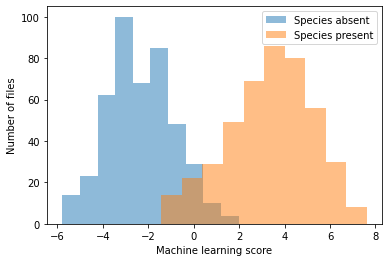

In [17]:
plt.hist(true_absent_scores, alpha=0.5, label='Species absent')
plt.hist(true_present_scores, alpha=0.5, label='Species present')
plt.legend()
plt.xlabel('Machine learning score')
plt.ylabel('Number of files')
plt.show()

This model performs fairly well at differentiating the validation files, which are segments of Xeno-Canto recordings. Note: this doesn't mean the model will perform similarly well on ARU recordings!

#### Load weights onto architecture

To use the model itself, access the dictionary's `'model_state_dict'` attribute:

In [18]:
weights = model_and_metadata['model_state_dict']

Now, apply these weights to the model architecture created above.

In [19]:
model.load_state_dict(weights)

<All keys matched successfully>

## Prepare prediction files

To actually use the model, we need to download and prepare a set of recordings. The model was trained to make predictions on spectrograms made from 5 second-long recordings, so we will have to split the recordings up and transform them into spectrograms.

As example data, we have provided a 1 minute-long soundscape which contains Wood Thrush vocalizations. 

The following code downloads this audio file into the `"prediction_example"` folder created above. If you prefer, you can also download this file at [this link](https://pitt.box.com/shared/z73eked7quh1t2pp93axzrrpq6wwydx0). Make sure to move it into the `"prediction_example"` folder and ensure that it is named `"1min.wav"`.

In [20]:
data_filename = folder_path.joinpath("1minexamplefile.wav")
download_from_box(
    link = "https://pitt.box.com/shared/static/z73eked7quh1t2pp93axzrrpq6wwydx0.wav",
    name = data_filename
)

The example soundscape must be split up into soundscapes of the same size as the ones the model was trained on. In this case, the soundscapes should be 5s long.

First, create a directory in which to save split files.

In [21]:
split_directory = folder_path.joinpath("split_files")
if not split_directory.exists(): split_directory.mkdir()

Next, load the 1-minute long file as an `Audio` object.

In [22]:
base_file = Audio.from_file(data_filename)

To split `base_file` into 5s long segments, use the `split` method of `opensoundscape.Audio`. This will return a list of dictionaries, containing a 5s long `Audio` object, and its start time and end time with respect to `base_file`. The argument `final_clip=None` only makes a difference if the source audio didn't have a length divisible by 5s, by removing the remainder clip so that we are only left with 5s long clips. For more information on the behavior of this argument, see the API Documentation.

In [23]:
split_files = base_file.split(
    clip_duration=5,
    clip_overlap=0,
    final_clip=None,
)

See what the first element of the resulting array looks like:

In [24]:
split_files[0]

{'clip': <Audio(samples=(160000,), sample_rate=32000)>,
 'clip_duration': 5.0,
 'begin_time': 0,
 'end_time': 5}

Save each of these split files in the directory created earlier. Save each of them with a prefix and the start and end times of the split with respect to the original file. In this case, make the prefix equal to the filename of the base file, without the extension (its stem):

In [25]:
split_prefix = data_filename.stem
split_prefix

'1minexamplefile'

The following loop saves each of the clips in the array.

In [26]:
filenames = []
for split_file_dict in split_files:
    # Extract the Audio object
    clip_audio = split_file_dict['clip']
    
    # The start and end time of this clip with respect to the original recording
    begin_time = split_file_dict['begin_time']
    end_time = split_file_dict['end_time']
    
    # Create a filename that starts with the filename of the original recording
    filename = split_directory.joinpath(f'{split_prefix}_{begin_time}s-{end_time}s.wav')
    
    # Keep track of the filenames in an array
    filenames.append(filename)
    
    # Save the filenames
    clip_audio.save(path=filename)

## Create a Dataset

Now that the data are split, we can create a "dataset" from them using OpenSoundscape's `SingleTargetAudioDataset`.  This structure takes in a `DataFrame` of filenames. It can be accessed like a list of the same length as the DataFrame of filenames. When it is accessed, it takes the filename, loads the audio at the filename, and transforms that audio into a spectrogram in the correct format to use for our machine learning models.

This dataset, `SingleTargetAudioDataset`, is intended for models that predict the presence of a single target, e.g., models that predict whether a single species is present in a file, like the model we are using. It can be used in both training and prediction, and has many options for implementing image augmentation during training (see the API Documentation). Just use the default options for prediction.

To create a dataset, first format the list of 5s clip filenames into a pandas `DataFrame`. Name the column containing the filenames `'file_path'`.

In [27]:
filename_column = 'file_path'
files_to_predict_on = pd.DataFrame(filenames, columns=[filename_column])

Additionally, the `SingleTargetAudioDataset` requires that we use a dictionary that associates numeric labels with the class names: 1 is for predicting a Wood Thrush's presence; 0 is for predicting a Wood Thrush's absence. This dictionary is packaged with the model under the key `'labels_yaml'`:

In [28]:
label_dict = yaml.safe_load(model_and_metadata['labels_yaml'])
label_dict

{0: 'hylocichla-mustelina-absent', 1: 'hylocichla-mustelina-present'}

Now create the `SingleTargetAudioDataset`.

In [29]:
test_dataset = SingleTargetAudioDataset(
    df=files_to_predict_on,
    filename_column=filename_column,
    label_dict=label_dict,
)

The `test_dataset` is a list of dictionaries. Each element of the list contains a dictionary for one of the files to predict on.

In [30]:
len(test_dataset)

12

Each dictionary in `test_dataset` has one or two keys. In all cases, the dictionary has a key `'X'` which refers to the spectrogram. If a dataset is created with true labels, the dictionary also has a `'y'` key which links to the true label. Because it is unknown which of these files contain Wood Thrush songs, no true labels were given when creating the dataset.

The spectrogram itself is stored as a PyTorch tensor. For example, here is the tensor of the first spectrogram:

In [31]:
first_tensor = test_dataset[0]['X']
first_tensor

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-0.2314, -0.1451,  0.1373,  ..., -0.0902, -0.1373, -0.0902],
         [-0.1529, -0.2157,  0.1922,  ..., -0.1451, -0.1686, -0.0275],
         [ 0.2784,  0.0275,  0.3647,  ...,  0.0510,  0.1059,  0.3176]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-0.2314, -0.1451,  0.1373,  ..., -0.0902, -0.1373, -0.0902],
         [-0.1529, -0.2157,  0.1922,  ..., -0.1451, -0.1686, -0.0275],
         [ 0.2784,  0.0275,  0.3647,  ...,  0.0510,  0.1059,  0.3176]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1

To view this spectrogram, use PyTorch's `transforms.ToPILImage()` function. This function returns a transformer. Call the transformer on the first tensor to display the spectrogram as an image.

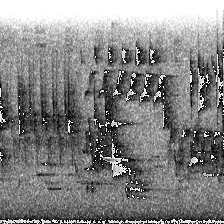

In [32]:
transformer = torchvision.transforms.ToPILImage()
transformer(first_tensor)

## Use model on prediction files

Finally, the model can be used for prediction. Use OpenSoundscape's `predict` function to call the model on the test dataset. The `label_dict` created above is used to make the classes interpretable; otherwise, the classes would just be numbered.

In [33]:
prediction_df = predict(model, test_dataset, label_dict=label_dict)
prediction_df

,hylocichla-mustelina-absent,hylocichla-mustelina-present
prediction_example/split_files/1minexamplefile_0s-5s.wav,-2.699836,2.345755
prediction_example/split_files/1minexamplefile_5s-10s.wav,-3.972310,4.026467
prediction_example/split_files/1minexamplefile_10s-15s.wav,-5.235929,5.631192
prediction_example/split_files/1minexamplefile_15s-20s.wav,-2.984634,2.917254
prediction_example/split_files/1minexamplefile_20s-25s.wav,-1.895094,2.359997
prediction_example/split_files/1minexamplefile_25s-30s.wav,-3.669389,4.548790
prediction_example/split_files/1minexamplefile_30s-35s.wav,-3.804515,4.256460
prediction_example/split_files/1minexamplefile_35s-40s.wav,-4.488552,4.726258
prediction_example/split_files/1minexamplefile_40s-45s.wav,-3.719126,3.582299
prediction_example/split_files/1minexamplefile_45s-50s.wav,-4.844445,4.841421


Interpreting these scores is the challenging part of machine learning. One typical method is to empirically determine a score threshold below which the species is considered absent and present, and listen to a sample of recordings above and below the threshold to determine the false positive and false negative rate of the threshold. 

Note that the classifier usually performs worse on autonomous recording unit data than it does on the validation set. In particular, the distributions of the species-present and species-absent values may have greater variance and may be centered on different values, closer to each other than in the validation set (see histograms above).

Finally, this command "cleans up" by deleting all the downloaded files and results. Only run this if you are ready to remove the results of this analysis.

In [34]:
import shutil
shutil.rmtree(folder_path)